Combine the results of the ridge model fitted by R's glmnet with the game data.

In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import nba_on_court as noc

In [15]:
coef_data   = pd.read_csv('../../results/coefficients.csv', index_col=0, header=None, names=['C'], skiprows=2)
coefs       = coef_data['C']
players     = pd.read_csv('../../design_matrices/odrapm_design.csv.gz', index_col=0).columns.to_series().iloc[1::2].astype(int).to_list() # every other item starting at position 1

First, create a DataFrame to export results to. Then fill in the DataFrame with desired metrics.

In [4]:
orapm = coefs.iloc[1::2].values
drapm = coefs.iloc[2::2].values

results = pd.DataFrame({
    'Player'        : noc.players_name(players),
    'ORAPM'         : orapm,
    'DRAPM'         : drapm,
    'RAPM'          : orapm - drapm,
    'Average PM'    : np.empty(len(orapm)) # to be filled
})

results

,Player,ORAPM,DRAPM,RAPM,Average PM
0,LeBron James,0.000145,-0.000040,0.000184,0.000000e+00
1,Udonis Haslem,-0.007523,-0.001203,-0.006321,6.952134e-310
2,Chris Paul,0.001162,-0.000063,0.001225,8.379353e-321
3,Kyle Lowry,0.000680,0.000206,0.000474,NaN
4,P.J. Tucker,0.000443,-0.000629,0.001072,5.786611e-307
...,...,...,...,...,...
212,Christian Braun,-0.001592,-0.000291,-0.001301,1.560051e-239
213,Josh Minott,-0.004047,0.001944,-0.005990,3.858271e-301
214,Peyton Watson,-0.003714,0.001847,-0.005562,3.748025e-301
215,David Roddy,-0.001386,0.000187,-0.001574,4.347925e-307


Infer "Average PM". It is defined like so:
1. Given a player, compute their Plus-Minus while they were on the court. Call this On Court Plus Minus (OnPM).
2. Compute the Plus-Minus while the player wasn't on the court. Call this Off Court Plus Minus (OffPM)
3. Average PM = (OnPM - OffPM) / Total Stints

Since Plus-Minus depends on whether the player is on Home or Away, stints in games where the player wasn't present were ignored.

In [5]:
data = pd.read_csv('../../data/processed_data_2022.csv', index_col=0) 
indicators = pd.read_csv('../../design_matrices/odrapm_design.csv.gz', usecols=range(2, 2 * (len(players)+1)))

games = pd.unique(data['GAME_ID'])

In [6]:
# calculate average pm for each player
# this is definitely not the most efficient way to do this
# but i'm too lazy to figure it out
for i in range(len(players)):
    onpm = 0
    offpm = 0
    total_stints = 0
    for game in games:
        bools: list[bool] = data['GAME_ID'] == game # specifying the data type for my IDE
        if not np.any(bools): # if the player isn't in the game
            continue
        current_data, current_indic = data[bools], indicators[bools]
        
        sign = np.sign(current_indic.sum())
        on_indicators = current_indic.iloc[:, 2*i] + current_indic.iloc[:, 2*i+1]
        off_indicators = ((~on_indicators.astype(bool)).astype(int)).mul(sign) # in case we need to swap -1, 0 instead of 1, 0
        
        onpm += (on_indicators * current_data['PM']).sum()
        offpm += (off_indicators * current_data['PM']).sum()
        total_stints += len(current_data)

    results.at[i, 'Average PM'] = (onpm - offpm) / total_stints

In [7]:
results.sort_values(by=['Average PM'], ascending=False, inplace=True)

results.to_csv('../../results/signed_intercept_results.csv')

# Analyze Results

In [10]:
results.sort_values(by=['RAPM'], ascending=False).head(50)

,Player,ORAPM,DRAPM,RAPM,Average PM
126,Aaron Holiday,0.009866,-0.005376,0.015242,-0.000159
39,Meyers Leonard,0.005623,-0.002395,0.008018,-0.000106
57,Thanasis Antetokounmpo,0.005623,-0.002395,0.008018,-0.000106
206,MarJon Beauchamp,0.005623,-0.002395,0.008018,-0.000106
193,Day'Ron Sharpe,0.001542,-0.006062,0.007604,-0.000529
17,Goran Dragic,0.004639,-0.001325,0.005964,-0.000211
72,Montrezl Harrell,0.002883,-0.001643,0.004526,-0.000159
175,Saddiq Bey,0.000788,-0.003226,0.004014,-0.001850
50,Mike Muscala,0.003442,-0.000492,0.003934,0.000687
53,Victor Oladipo,0.001925,-0.001998,0.003923,-0.000053


<Axes: xlabel='RAPM', ylabel='Average PM'>

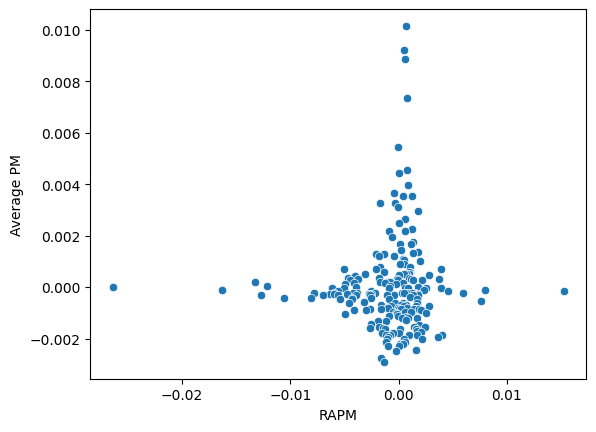

In [11]:
sns.scatterplot(x=results['RAPM'], y=results['Average PM'])